# Assignment description

Build synthetic scale-free networks according to the BA model. Consider $m$ new connections for each node inserted. Calculate empiracally properties like CC and APL. Compare the obtained results for networks of same size generated by Poisson model and WS model. What do you observe?

In [2]:
%config Completer.use_jedi = False

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Graph parameters

We're going to build some Erdos-Renyi (ER) models varying its parameters. When we fix a connection probability we're also fixing its degree. So we'll create some realizations for each combination of n and z.

In [3]:
def find_percolation_threshold(n = 1000, threshold = 0.5, step = 0.2):
    graphs_dict = dict()
    avg_degree = 0
    while True:
        nodes = n
        graphs_dict[avg_degree] = dict()

        probability = avg_degree/nodes        
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_dict[avg_degree][probability] = graph
        giant = graph.clusters().giant()
        graphs_dict[avg_degree][probability]["giant"] = giant
        giant_fraction = giant.vcount()/n
        avg_degree += step
        if giant_fraction > threshold:
            return graphs_dict

percolations = find_percolation_threshold()

In [4]:
percolations

{0: {0.0: <igraph.Graph at 0x7f7ff32be350>},
 0.2: {0.0002: <igraph.Graph at 0x7f7ff32be450>},
 0.4: {0.0004: <igraph.Graph at 0x7f7ff32be650>},
 0.6000000000000001: {0.0006000000000000001: <igraph.Graph at 0x7f7ff32be850>},
 0.8: {0.0008: <igraph.Graph at 0x7f7ff32bea50>},
 1.0: {0.001: <igraph.Graph at 0x7f7ff32bec50>},
 1.2: {0.0012: <igraph.Graph at 0x7f7ff32bee50>},
 1.4: {0.0014: <igraph.Graph at 0x7f7ff3361150>}}

# Graph building

## Barabasi-Albert networks

In [5]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
ensemble_size = 10
m_number = np.arange(1, 6, 1)

In [6]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, m_number])

barabasi_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    m_value = int(network_property[1])
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Barabasi(n = nodes, m = m_value)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(m_value) + "_m"
    barabasi_graphs[key] = dict()
    barabasi_graphs[key]['graphs'] = graphs_list
    barabasi_graphs[key]["nodes"] = nodes
    barabasi_graphs[key]["m"] = m_value

CPU times: user 251 ms, sys: 12.7 ms, total: 264 ms
Wall time: 283 ms


In [7]:
%%time
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
m_values = list()
degree_number = list()

for params in barabasi_graphs.keys():
    for graph in barabasi_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_avglocal_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(barabasi_graphs[params]["nodes"])
        m_values.append(barabasi_graphs[params]["m"]) 
        edges_number.append(len(graph.get_edgelist()))
        degree_number.append(np.mean(graph.degree()))
        

CPU times: user 1min 44s, sys: 283 ms, total: 1min 44s
Wall time: 1min 45s


In [8]:
barabasi_analysis = pd.DataFrame()
barabasi_analysis["nodes_number"] = nodes_number
barabasi_analysis["avg_degree"] = np.round(degree_number)
barabasi_analysis["m_values"] = m_values
barabasi_analysis["avg_path_length"] = avg_path_length
barabasi_analysis["clustering_coefficient"] = clustering_coefficient

barabasi_analysis.fillna(0, inplace = True)
barabasi_analysis.head()

,nodes_number,avg_degree,m_values,avg_path_length,clustering_coefficient
0,1000,2.0,1,8.428987,0.000000
1,1000,2.0,1,8.440424,0.000000
2,1000,4.0,2,4.384767,0.013242
3,1000,4.0,2,4.326314,0.013759
4,1000,6.0,3,3.617642,0.018653


### APL and CC plotting

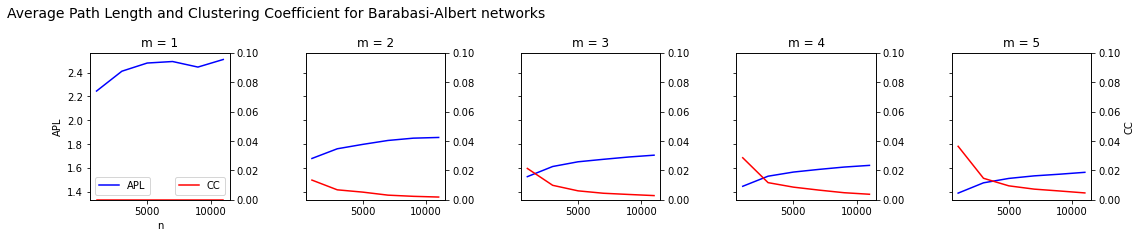

In [250]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "m_values"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

m_values = df_plot["m_values"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(m_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(m_values)):
    # Filter the dataset
    data = df_plot[df_plot["m_values"].isin([m_values[i]])]
    ax[i].plot(data[ ("nodes_number")], np.log1p(data[("mean", "avg_path_length")]), color = "blue")
    
    ax2 = ax[i].twinx()
    ax2.plot(data[ ("nodes_number")], np.log1p(data[("mean", "clustering_coefficient")]), 
             color = "red")
    ax2.set_ylim(0, 0.1)
    
    # Titles and legends
    ax[i].set_title(f"m = {m_values[i]}")
    
    if i == 0:
        _ = ax2.legend(["CC"], loc = "lower right")
        
    
_ = ax[0].set_ylabel("APL")
_ = ax[0].set_xlabel("n")
_ = ax2.set_ylabel("CC")
_ = ax[0].legend(["APL"])
_ = fig.text(0, 0.9, 
             'Average Path Length and Clustering Coefficient for Barabasi-Albert networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

As the we change network parameters, we don observe a small world effect since APL is decreasing. Also CC values very low for all network configuration.

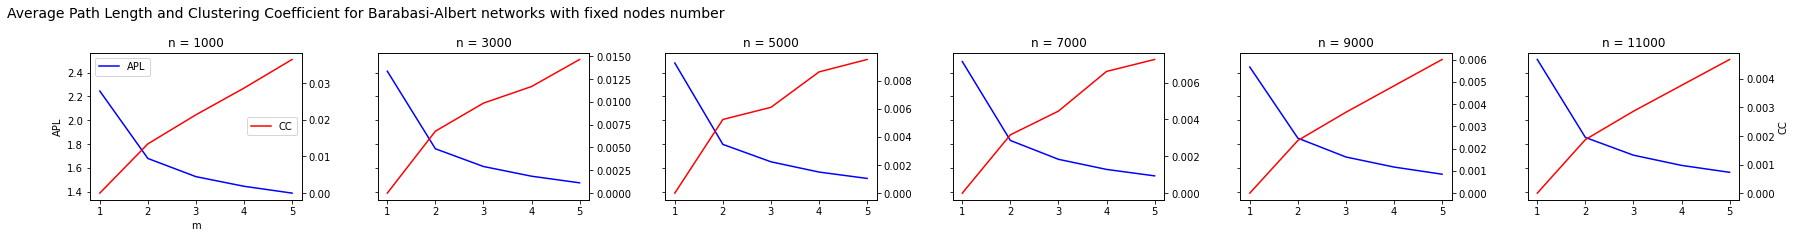

In [259]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "m_values"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

nodes_values = df_plot["nodes_number"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(nodes_values), figsize = (25, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(nodes_values)):
    # Filter the dataset
    data = df_plot[df_plot["nodes_number"].isin([nodes_values[i]])]
    
    ax[i].plot(data[ ("m_values")], np.log1p(data[("mean", "avg_path_length")]), color = 'blue')
    
    # plot CC line to comparisons
    ax2 = ax[i].twinx()
    ax2.plot(data[ ("m_values")], np.log1p(data[("mean", "clustering_coefficient")]), 
             color = "red")
        
    
    if i == 0:
        _ = ax2.legend(["CC"], loc = "center right")
    
    # Titles and legends
    ax[i].set_title(f"n = {np.round(nodes_values[i], 2)}")
    
_ = ax[0].set_ylabel("APL")
_ = ax[0].set_xlabel("m")
_ = ax[0].legend(["APL"], loc = "upper left")
_ = ax2.set_ylabel("CC")
_ = fig.text(0, 0.9, 
             'Average Path Length and Clustering Coefficient for Barabasi-Albert networks with fixed nodes number', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

## Poisson networks

In [169]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
avg_degree_array = [2, 4, 6, 8, 10] #np.arange(0, 3.2, 0.2)
ensemble_size = 10

In [170]:
# %%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, avg_degree_array])

poisson_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    
    if network_property[1] in ["log", "2log"]:
        degree = np.round(np.log(nodes), 2)
        key = str(nodes) + '_nodes__' + network_property[1] + "_degree"
    else:
        degree = network_property[1]
        key = str(nodes) + '_nodes__' + str(degree) + "_degree"
    probability = degree/nodes
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_list.append(graph)
    
    poisson_graphs[key] = dict()
    poisson_graphs[key]['graphs'] = graphs_list
    poisson_graphs[key]["nodes"] = nodes
    poisson_graphs[key]["degree"] = network_property[1]
    poisson_graphs[key]["probability"] = probability    

In [171]:
%%time
# Calculate some metrics for each graph realization

nodes_number = list()
edges_number = list()
degree_number = list()
clustering_coefficient = list()
avg_path_length = list()
probabilities_values = list()

for params in poisson_graphs.keys():
    for graph in poisson_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_avglocal_undirected())
        avg_path_length.append(graph.average_path_length())
        edges_number.append(len(graph.get_edgelist()))
        nodes_number.append(poisson_graphs[params]["nodes"])     
        probabilities_values.append(poisson_graphs[params]["probability"])
        degree_number.append(np.mean(graph.degree()))

CPU times: user 1min 52s, sys: 205 ms, total: 1min 52s
Wall time: 1min 53s


In [172]:
poisson_analysis = pd.DataFrame()

poisson_analysis["nodes_number"] = nodes_number
poisson_analysis["edges_number"] = edges_number
poisson_analysis["avg_degree"] = np.round(degree_number)
poisson_analysis["probability"] = probabilities_values
poisson_analysis["clustering_coefficient"] = clustering_coefficient
poisson_analysis["avg_path_length"] = avg_path_length

poisson_analysis.head()

,nodes_number,edges_number,avg_degree,probability,clustering_coefficient,avg_path_length
0,1000,934,2.0,0.002,0.003873,9.570902
1,1000,1031,2.0,0.002,0.002547,8.994649
2,1000,2008,4.0,0.004,0.003537,5.080680
3,1000,1947,4.0,0.004,0.004472,5.192920
4,1000,3074,6.0,0.006,0.006898,4.001940


### APL and CC plotting

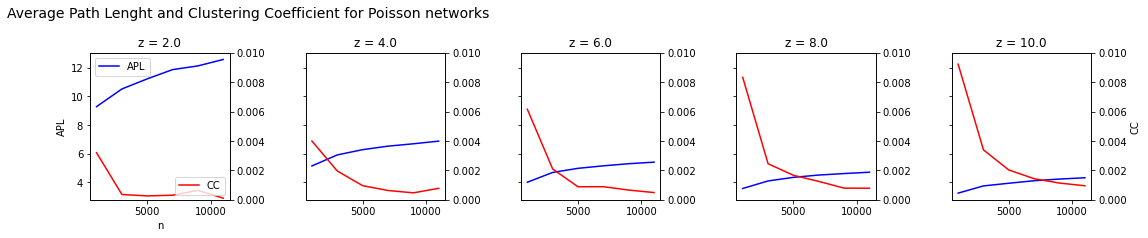

In [268]:
df_plot = poisson_analysis.pivot_table(index = ["nodes_number", "avg_degree"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

degree_values = df_plot["avg_degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(degree_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(degree_values)):
    # Filter the dataset
    data = df_plot[df_plot["avg_degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], color = "blue")
    
    ax2 = ax[i].twinx()
    ax2.plot(data[ ("nodes_number")], np.log1p(data[("mean", "clustering_coefficient")]), 
             color = "red")
    ax2.set_ylim(0, 0.01)
    
    # Titles and legends
    ax[i].set_title(f"z = {degree_values[i]}")
    
    if i == 0:
        _ = ax2.legend(["CC"], loc = "lower right")
        
    
_ = ax[0].set_ylabel("APL")
_ = ax[0].set_xlabel("n")
_ = ax2.set_ylabel("CC")
_ = ax[0].legend(["APL"])
_ = fig.text(0, 0.9, 
             'Average Path Lenght and Clustering Coefficient for Poisson networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

In [272]:
poisson_analysis[(poisson_analysis["avg_degree"] == 8) 
                & (poisson_analysis["nodes_number"] == 11000)][["clustering_coefficient", "avg_path_length"]].mean()

clustering_coefficient    0.000789
avg_path_length           4.697789
dtype: float64

In [275]:
barabasi_analysis[(barabasi_analysis["m_values"] == 4) 
                & (barabasi_analysis["nodes_number"] == 11000)][["clustering_coefficient", "avg_path_length"]].mean()

clustering_coefficient    0.003777
avg_path_length           4.053242
dtype: float64

For ER networks we observe also low values for CC but higher values for APL compared to BA networks.

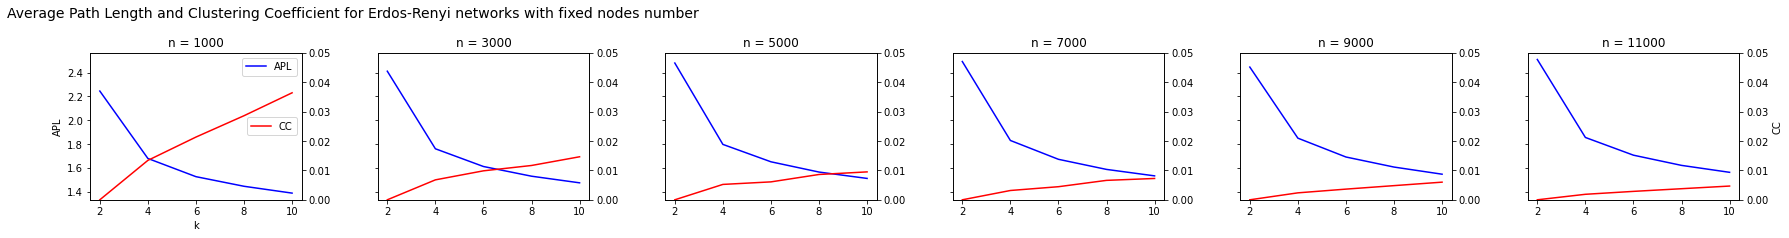

In [263]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "avg_degree"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

nodes_values = df_plot["nodes_number"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(nodes_values), figsize = (25, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(nodes_values)):
    # Filter the dataset
    data = df_plot[df_plot["nodes_number"].isin([nodes_values[i]])]
    
    ax[i].plot(data[ ("avg_degree")], np.log1p(data[("mean", "avg_path_length")]), color = 'blue')
    
    # plot CC line to comparisons
    ax2 = ax[i].twinx()
    ax2.plot(data[ ("avg_degree")], np.log1p(data[("mean", "clustering_coefficient")]), 
             color = "red")
    ax2.set_ylim(0, 0.05)
    
    
    if i == 0:
        _ = ax2.legend(["CC"], loc = "center right")
    
    # Titles and legends
    ax[i].set_title(f"n = {np.round(nodes_values[i], 2)}")
    
_ = ax[0].set_ylabel("APL")
_ = ax[0].set_xlabel("k")
_ = ax[0].legend(["APL"])
_ = ax2.set_ylabel("CC")
_ = fig.text(0, 0.9, 
             'Average Path Length and Clustering Coefficient for Erdos-Renyi networks with fixed nodes number', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

For the ER netwoks we observe that the APL decreases as we increse value for $m$. This behavior is similar to the one observed for BA networks.

## Watts-Strogatz networks

In [188]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]

ensemble_size = 10
steps_number = np.arange(2, 3, 1)
rewiring_probabilities = np.arange(0, 0.35, 0.05)

In [190]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, steps_number, rewiring_probabilities])

watts_strogatz_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    steps = int(network_property[1])
    rewiring = network_property[2]
    
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Watts_Strogatz(dim = 1, size = nodes, nei = steps, p = rewiring)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(steps) + "_nei__" + str(rewiring) + "_rewiring_prob"
    watts_strogatz_graphs[key] = dict()
    watts_strogatz_graphs[key]['graphs'] = graphs_list
    watts_strogatz_graphs[key]["nodes"] = nodes
    watts_strogatz_graphs[key]["rewiring_prob"] = rewiring

CPU times: user 1.36 s, sys: 69.2 ms, total: 1.43 s
Wall time: 1.46 s


In [191]:
%%time
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
rewiring_prob_values = list()
degree_number = list()
for params in watts_strogatz_graphs.keys():
    for graph in watts_strogatz_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_avglocal_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(watts_strogatz_graphs[params]["nodes"])
        rewiring_prob_values.append(watts_strogatz_graphs[params]["rewiring_prob"]) 
        edges_number.append(len(graph.get_edgelist()))
        degree_number.append(np.mean(graph.degree()))
        
        
watts_strogatz_analysis = pd.DataFrame()
watts_strogatz_analysis["nodes_number"] = nodes_number
watts_strogatz_analysis["avg_degree"] = np.round(degree_number)
watts_strogatz_analysis["rewiring_prob"] = rewiring_prob_values
watts_strogatz_analysis["avg_path_length"] = avg_path_length
watts_strogatz_analysis["clustering_coefficient"] = clustering_coefficient

watts_strogatz_analysis.fillna(0, inplace = True)

CPU times: user 11min 18s, sys: 2 s, total: 11min 20s
Wall time: 11min 29s


### APL and CC plotting

In [198]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]

ensemble_size = 1
steps_number = np.arange(1, 6, 1)

# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, steps_number])

lattice_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    steps = int(network_property[1])    
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Lattice(dim = [nodes], nei = steps, directed=False, mutual=True, circular=True)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(steps) + "_nei__" + str(rewiring) + "_rewiring_prob"
    lattice_graphs[key] = dict()
    lattice_graphs[key]['graphs'] = graphs_list
    lattice_graphs[key]["nodes"] = nodes

    
# Analytics
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
rewiring_prob_values = list()
degree_number = list()
for params in lattice_graphs.keys():
    for graph in lattice_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_avglocal_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(lattice_graphs[params]["nodes"])
        edges_number.append(len(graph.get_edgelist()))
        degree_number.append(np.mean(graph.degree()))
        
        
lattice_analysis = pd.DataFrame()
lattice_analysis["nodes_number"] = nodes_number
lattice_analysis["avg_degree"] = np.round(degree_number)
lattice_analysis["avg_path_length"] = avg_path_length
lattice_analysis["clustering_coefficient"] = clustering_coefficient

lattice_analysis.fillna(0, inplace = True)

In [200]:
lattice_analysis.head()

,nodes_number,avg_degree,avg_path_length,clustering_coefficient
0,1000,2.0,250.250250,0.000000
1,1000,4.0,125.375375,0.500000
2,1000,6.0,83.750751,0.600000
3,1000,8.0,62.937938,0.642857
4,1000,10.0,50.450450,0.666667


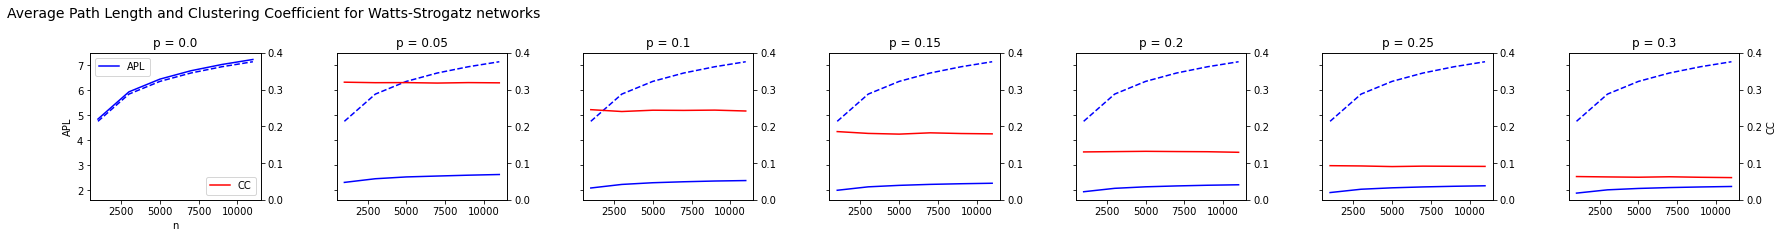

In [256]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "rewiring_prob"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

lattice_plot = lattice_analysis.pivot_table(index = ["nodes_number"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()


rewiring_values = df_plot["rewiring_prob"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(rewiring_values), figsize = (25, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(rewiring_values)):
    # Filter the dataset
    data = df_plot[df_plot["rewiring_prob"].isin([rewiring_values[i]])]
    
    ax[i].plot(data[ ("nodes_number")], np.log1p(data[("mean", "avg_path_length")]), color = 'blue')
    ax[i].plot(lattice_plot[("nodes_number")], np.log1p(lattice_plot[("mean", "avg_path_length")]), color = "blue", linestyle = "dashed")
    
    # plot CC line to comparisons
    ax2 = ax[i].twinx()
    ax2.set_ylim(0, 0.4)
    ax2.plot(data[ ("nodes_number")], np.log1p(data[("mean", "clustering_coefficient")]), 
             color = "red")
        
    
    if i == 0:
        _ = ax2.legend(["CC"], loc = "lower right")
    
    # Titles and legends
    ax[i].set_title(f"p = {np.round(rewiring_values[i], 2)}")
    
_ = ax[0].set_ylabel("APL")
_ = ax[0].set_xlabel("n")

_ = ax[0].legend(["APL"])
_ = ax2.set_ylabel("CC")
_ = fig.text(0, 0.9, 
             'Average Path Length and Clustering Coefficient for Watts-Strogatz networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

For WS we observe the same behavior compared to ER and BA networks but its values of CC are higher compared to BA and ER networks. For APL value we observe that its values decreases as we increase value for $p$ (rewiring probability), getting closer to ER and BA values. The dashed line is the APL for a lattice network of the same size of WS networks.

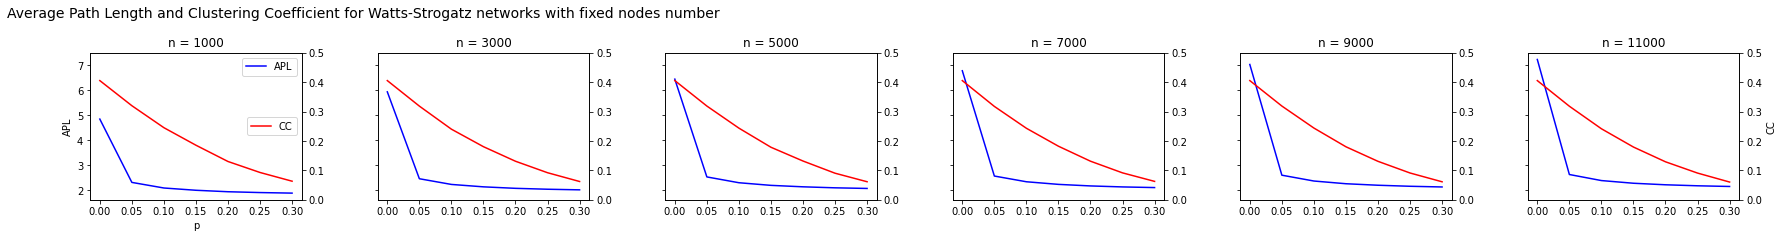

In [264]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "rewiring_prob"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

nodes_values = df_plot["nodes_number"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(nodes_values), figsize = (25, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(nodes_values)):
    # Filter the dataset
    data = df_plot[df_plot["nodes_number"].isin([nodes_values[i]])]
    
    ax[i].plot(data[ ("rewiring_prob")], np.log1p(data[("mean", "avg_path_length")]), color = 'blue')
    
    # plot CC line to comparisons
    ax2 = ax[i].twinx()
    ax2.plot(data[ ("rewiring_prob")], np.log1p(data[("mean", "clustering_coefficient")]), 
             color = "red")
        
    ax2.set_ylim(0, 0.5)
    
    if i == 0:
        _ = ax2.legend(["CC"], loc = "center right")
    
    # Titles and legends
    ax[i].set_title(f"n = {np.round(nodes_values[i], 2)}")
    
_ = ax[0].set_ylabel("APL")
_ = ax[0].set_xlabel("p")
_ = ax[0].legend(["APL"])
_ = ax2.set_ylabel("CC")
_ = fig.text(0, 0.9, 
             'Average Path Length and Clustering Coefficient for Watts-Strogatz networks with fixed nodes number', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

In [284]:
watts_strogatz_analysis[(watts_strogatz_analysis["rewiring_prob"] == 0.25) 
                & (watts_strogatz_analysis["nodes_number"] == 11000)]#[["clustering_coefficient", "avg_path_length"]].mean()

,network,nodes_number,avg_degree,rewiring_prob,avg_path_length,clustering_coefficient
400,WS,11000,4.0,0.25,7.709589,0.093392
401,WS,11000,4.0,0.25,7.727429,0.096120
402,WS,11000,4.0,0.25,7.726214,0.097858
403,WS,11000,4.0,0.25,7.734659,0.095617
404,WS,11000,4.0,0.25,7.704717,0.090901
405,WS,11000,4.0,0.25,7.739737,0.095784
406,WS,11000,4.0,0.25,7.750883,0.096712
407,WS,11000,4.0,0.25,7.715386,0.094446
408,WS,11000,4.0,0.25,7.723375,0.094755
409,WS,11000,4.0,0.25,7.738648,0.095876


## Plotting on the same chart

In [235]:
poisson_analysis.fillna(0, inplace = True)
poisson_analysis.insert(loc = 0, column = 'network', value = 'ER')

In [236]:
barabasi_analysis.insert(loc = 0, column = 'network', value = 'BA')
watts_strogatz_analysis.insert(loc = 0, column = 'network', value = 'WS')

In [237]:
agg_data = \
pd.concat([poisson_analysis[['network', 'nodes_number', 'avg_degree', 'clustering_coefficient', 'avg_path_length']],
           barabasi_analysis[['network', 'nodes_number', 'avg_degree', 'clustering_coefficient', 'avg_path_length']],
           watts_strogatz_analysis[['network', 'nodes_number', 'avg_degree', 'clustering_coefficient', 'avg_path_length']]
          ])

In [245]:
agg_data.head()

,network,nodes_number,avg_degree,clustering_coefficient,avg_path_length
0,ER,1000,2.0,0.003873,9.570902
1,ER,1000,2.0,0.002547,8.994649
2,ER,1000,4.0,0.003537,5.080680
3,ER,1000,4.0,0.004472,5.192920
4,ER,1000,6.0,0.006898,4.001940
